##  1. Imports

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm 

## 2. Configuration

In [2]:
DATA_DIR = '/kaggle/input/music-instruments/music_instruments/'
BATCH_SIZE = 32
NUM_EPOCHS = 10
NUM_CLASSES = 5
if torch.cuda.is_available():
    DEVICE="cude"
elif torch.backends.mps.is_available():
    DEVICE="mps"
else:
    DEVICE="cpu"

print(f"Using Device - {DEVICE}")

Using Device - mps


## 3. Transforms

In [3]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])



## 4. Dataset and Class Names

In [4]:
DATA_DIR = "/Users/yash/Library/IntelliShelf/dataset/images"

In [5]:
full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)
class_names = full_dataset.classes
print("Classes:", class_names)

Classes: ['drum', 'flute', 'guitar', 'tabla', 'violin']


## 5. Train/Validation Split

In [6]:
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

In [7]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

## 6. Load Pretrained Model (ResNet18)

In [8]:
model = models.resnet18(pretrained=True)

/Users/yash/Library/IntelliShelf/IntelliShelf/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/yash/Library/IntelliShelf/IntelliShelf/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Replace final layer

In [9]:
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

In [10]:
model = model.to(DEVICE)

In [11]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 7. Loss and Optimizer

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

## 8. Training Function

In [13]:
def train(model, loader):
    model.train()
    total_loss = 0
    loop = tqdm(loader, desc="Training", leave=False)
    for inputs, labels in loop:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())
    return total_loss / len(loader)

##  9. Evaluation Function

In [15]:
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    loop = tqdm(loader, desc="Evaluating", leave=False)
    with torch.no_grad():
        for inputs, labels in loop:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

## 10. Train the Model

In [16]:
for epoch in range(NUM_EPOCHS):
    print(f"\n🌟 Epoch {epoch+1}/{NUM_EPOCHS}")
    train_loss = train(model, train_loader)
    val_acc = evaluate(model, val_loader)
    print(f"✅ Loss: {train_loss:.4f} - 🎯 Val Accuracy: {val_acc:.4f}")


🌟 Epoch 1/10


✅ Loss: 0.8351 - 🎯 Val Accuracy: 0.5330

🌟 Epoch 2/10


✅ Loss: 0.5852 - 🎯 Val Accuracy: 0.7582

🌟 Epoch 3/10


✅ Loss: 0.3902 - 🎯 Val Accuracy: 0.7473

🌟 Epoch 4/10


✅ Loss: 0.3885 - 🎯 Val Accuracy: 0.7802

🌟 Epoch 5/10


✅ Loss: 0.3570 - 🎯 Val Accuracy: 0.7473

🌟 Epoch 6/10


✅ Loss: 0.2426 - 🎯 Val Accuracy: 0.8681

🌟 Epoch 7/10


✅ Loss: 0.2069 - 🎯 Val Accuracy: 0.7363

🌟 Epoch 8/10


✅ Loss: 0.2286 - 🎯 Val Accuracy: 0.8297

🌟 Epoch 9/10


✅ Loss: 0.1960 - 🎯 Val Accuracy: 0.8022

🌟 Epoch 10/10


✅ Loss: 0.1755 - 🎯 Val Accuracy: 0.8571


## 11. Visualize Predictions

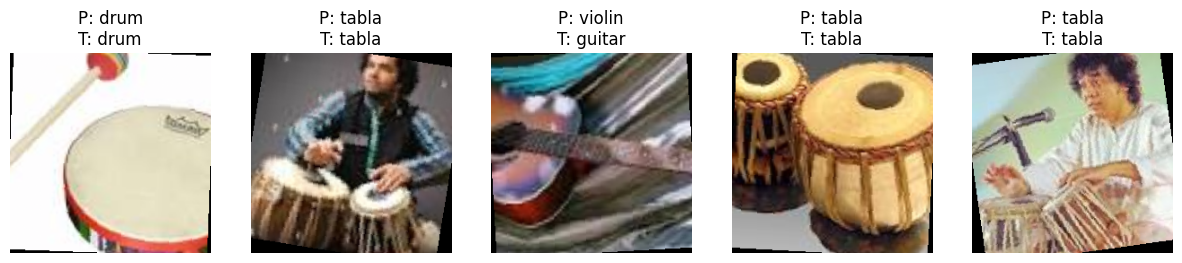

In [19]:
def imshow(img, title):
    img = img.cpu().permute(1, 2, 0)
    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    img = img.clamp(0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

def visualize_predictions(model, loader, num_images=5):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(15, 3))
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for i in range(inputs.size(0)):
                if images_shown == num_images:
                    return
                plt.subplot(1, num_images, images_shown + 1)
                imshow(inputs[i], f"P: {class_names[preds[i]]}\nT: {class_names[labels[i]]}")
                images_shown += 1
    plt.tight_layout()

visualize_predictions(model, val_loader)

In [ ]:
import os

os.makedirs("model", exist_ok=True)
torch.save(model, "model/full_model.pth")

In [31]:
import torch
from PIL import Image
from torchvision import transforms

model = torch.load("../model/classify.pth", map_location=DEVICE, weights_only=False)
model.eval()                            
model.to(DEVICE)                     

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

img_path = DATA_DIR = "/Users/yash/Library/IntelliShelf/dataset/images/violin/0002.jpg"                    
image = Image.open(img_path).convert("RGB")
input_tensor = preprocess(image).unsqueeze(0).to(DEVICE)

with torch.no_grad():
    logits = model(input_tensor)
    probs  = torch.softmax(logits, dim=1)

top_prob, pred_idx = probs.max(dim=1)
print("Predicted index:", pred_idx.item(), "  confidence:", top_prob.item())
print(class_names[pred_idx.item()])


Predicted index: 4   confidence: 0.999983549118042
violin
